# 1. Introduction



Sign language is a used as a way of communicating through facial expression, body language and hands. It is widely used by the deaf community and/or people who are hard of hearing. A sign can either be expressed as a gesture, or by means of fingerspelling (also called _dactylology_).

One sign of which the semantically and lexical meaning is not often well-defined is the _Palms-Open_ (PO) sign, also referred to as the _Palms-Up_ sign. This sign is formed by the rotation of one or both open hands towards an upward position. This notebook contains all results for binary classification to detect the PO sign by means of video processing. 

The PO sign is shown below.
<img src="figures/PO sign.png">

Of the total NGT corpus, three videos are used:
- CNGT0001_S003
- CNGT0001_S004
- CNGT0004_S003

Of these videos, _Open Pose_ features are collected. These features are keypoints, where one keypoint indicates a particular joint in the body, face or hand. OpenPose outputs a JSON format with a mapping from the body to keypoints, where the location coordinates for each keypoint in space are described. This can either be in 2D (i.e. $(x,y)$) or 3D (i.e. $(x,y,z)$). In this research, the 2D keypoints are used. 

The keypoints of respectively the body, face and hand are shown below.

<div align="center"> **Keypoints body** </div>
<img src="figures/Keypoints_body.png">

<div align="center"> **Keypoints face** </div>
<img src="figures/Keypoints_face.png">

<div align="center"> Keypoints hand**</div>
<img src="figures/Keypoints_hand.png">




# 2. Prepare Notebook

Here, all the required libraries for this research are imported.

In [1]:
import sys
print(sys.version, sys.platform, sys.executable)

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0] linux /usr/bin/python3


In [2]:
#import required libraries
import tarfile, csv
import sys
import json
import functions as func
import cv2
import csv
import itertools
from IPython.display import YouTubeVideo, HTML
from utils import animate, print_rest_positions, print_statistics
from color_histogram import  print_frame_histogram, get_frame_histogram_vector, split_video_sections
from rest_pose_rules import detect_rest_position_1, get_rest_position_groups
import os
import re
import imblearn
import sklearn


# 3. Get Data

Now we collect the data and prepare it for usage.

In [21]:
#Set relative paths
rel_path_videos = "./videos/"
rel_path_keypoints = "./keypoints_json/"
rel_path_features =  "./features/"
rel_path_tune_results = "./tune_results/"
rel_path_dictionaries = "./dictionaries/"


As the used videos and _Open Pose_ keypoints don't contain people (and thus useful information) in every frame, offsets are defined for both the videos and corresponding keypoints. These offsets are stored in **offset_dictionary_video** and **offset_dictionary_keypoints** respectively.

Each offset is defined as a tuple (_first frame_, _last frame_) where _first frame_ corresponds to the first frame number where a person is detected. Likewise, _last frame_ corresponds to the last frame number where a person is detected.

In [27]:
#Get information of videos containing annotated PO signs
annotated_filename = "CorpusNGT_PO.csv"
annotated_dictionary = func.make_annotated_dictionary(annotated_filename)
key = list(annotated_dictionary)[0]

#Get all filenames of the videos
filenames_videos = sorted(func.get_all_filepaths(rel_path_videos))


#Get offset dictionary for videos (create if not existing, otherwise load from file)
filename_offset_videos = rel_path_dictionaries+ 'offset_dictionary_videos.p'
if(os.path.exists(filename_offset_videos)):
    offset_dictionary_video = func.load_dictionary(filename_offset_videos)
else:
    offset_dictionary_video = func.get_dictionary_offsets_videos(rel_path_videos, list(annotated_dictionary), 3)
    func.save_dictionary(filename_offset_videos,offset_dictionary_video)

print("Offsets videos:{}".format(offset_dictionary_video))

#Get offset dictionary of OP keypoints    
filename_offset_keypoints = rel_path_dictionaries + 'offset_dictionary_keypoints.p'
if(os.path.exists(filename_offset_keypoints)):
    offset_dictionary_keypoints = func.load_dictionary(filename_offset_keypoints)
else:
    offset_dictionary_keypoints = get_dictionary_offsets_keypoints(rel_path_keypoints, list(annotated_dictionary),  3, offset_dictionary_video)
    func.save_dictionary(filename_offset_keypoints,offset_dictionary_keypoints)    

print("Offsets keypoints:{}\n".format(offset_dictionary_keypoints))


amount_frames_first, fps_first = func.get_frames_stats(rel_path_videos + filenames_videos[0] )
amount_frames_second, fps_second = func.get_frames_stats(rel_path_videos + filenames_videos[1] )
amount_frames_third, fps_third = func.get_frames_stats(rel_path_videos + filenames_videos[2] )
print("Amount frames {}:{}".format(filenames_videos[0], amount_frames_first))
print("Amount frames {}:{}".format(filenames_videos[1], amount_frames_second))
print("Amount frames {}:{}".format(filenames_videos[2], amount_frames_third))

Offsets videos:{'CNGT0001_S003': (75, 4089), 'CNGT0001_S004': (75, 4089), 'CNGT0004_S003': (75, 8506)}
Offsets keypoints:{'CNGT0001_S003': (59, 4073), 'CNGT0001_S004': (59, 4073), 'CNGT0004_S003': (59, 8490)}

Amount frames CNGT0001_S003_b.mpg:4115.0
Amount frames CNGT0001_S004_b.mpg:4115.0
Amount frames CNGT0004_S003_b.mpg:8532.0


Above, the offsets for the videos and keypoints are shown. We see that for instance for the first video (CNGT0001_S003), the video contains a person from frame number 75 until 4089. 




# 4. Inspect Data
Now that we prepared the data, we can inspect the data of the videos and the keypoints of Open Pose.



In [23]:
#Inspect first frame (annotated with PO) of first video
first_videoname = list(annotated_dictionary.keys())[0]
print("{}: \n {}".format(first_videoname,annotated_dictionary[first_videoname][0]))




CNGT0001_S003: 
 {'tiername': 'GlossL S1', 'tiertype': 'gloss', 'tierpart': 'S003', 'annotation': 'PO', 'tierannotation': 'SG', 'hitlength': '2', 'beginannotation': '65040', 'durationannotation': '600', 'hitposintier': '5', 'leftcontext': 'EDE  AMSTERDAM  AANSLUITEN', 'rightcontext': 'PO  KLAAR-A  WISSELEN'}


As we defined in the offset dictionaries, we know the begin- and end frame of a video and Open Pose keypoins containing a person. To show that this is true for the first video (between frames 75-4089), we plotted the frames of interest.

Amount frames 4115.0, Frames/second: 25.0


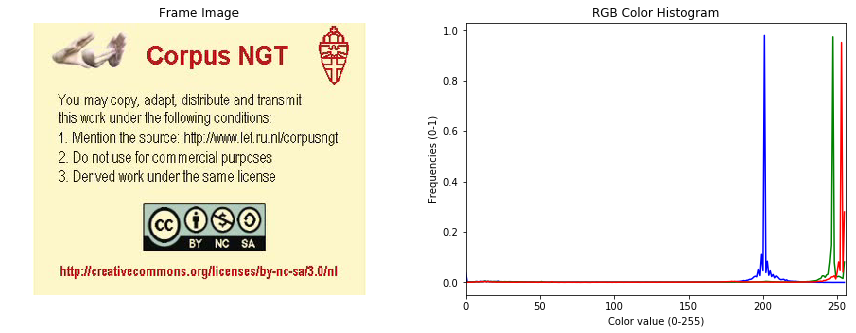

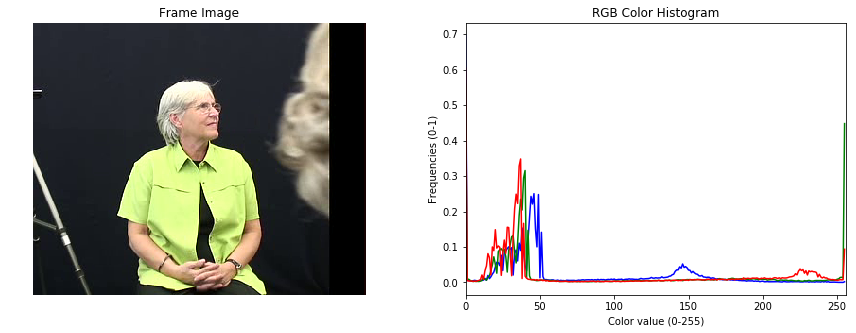

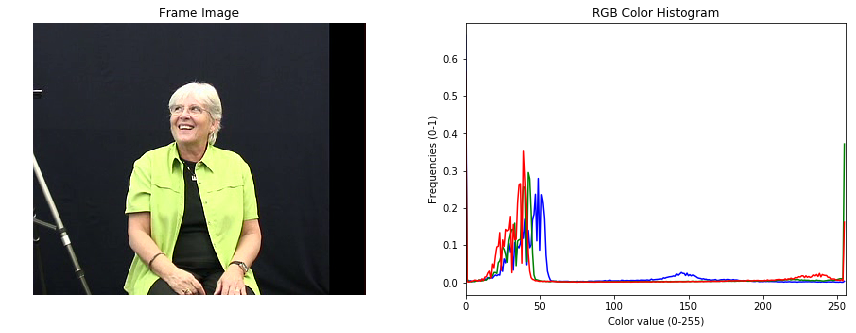

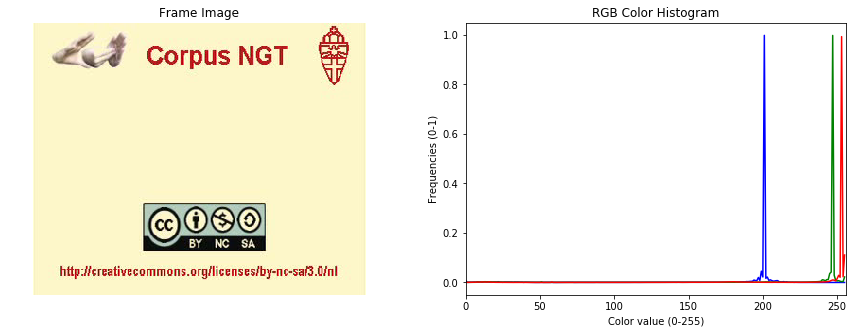

In [6]:
path_first_video = func.get_path_video(rel_path_videos,key)

amount_frames, fps = func.get_frames_stats(path_first_video)
print("Amount frames {}, Frames/second: {}".format(amount_frames,fps))



video = cv2.VideoCapture(path_first_video)


print_frame_histogram(video, frame_number=74)    
print_frame_histogram(video, frame_number=75)
print_frame_histogram(video, frame_number=4089)
print_frame_histogram(video, frame_number=4090)




In [7]:
key = list(annotated_dictionary)[0]
path_first_frame = func.get_path_keypoints(rel_path_keypoints, 85, key)

print(path_first_frame)



=with open(path_first_frame) as f:
    data = json.load(f)
    print("Keys first lvl: {}".format(data.keys()))
    data_person = data['people'][0]
    print("Keys 'people': {}".format(data_person.keys()))
    body_x = data_person['pose_keypoints_2d'][1::3]
    print(body_x)
    

./keypoints_json/CNGT0001_S003/CNGT0001_S003_b_000000000085_keypoints.json
Keys first lvl: dict_keys(['version', 'people'])
Keys 'people': dict_keys(['pose_keypoints_2d', 'face_keypoints_2d', 'hand_left_keypoints_2d', 'hand_right_keypoints_2d', 'pose_keypoints_3d', 'face_keypoints_3d', 'hand_left_keypoints_3d', 'hand_right_keypoints_3d'])
[89.9045, 148.731, 151.845, 222.382, 260.811, 147.147, 216.95, 255.373, 278.088, 277.307, 0, 0, 278.08, 0, 0, 85.1945, 84.3859, 103.245, 0, 0, 0, 0, 0, 0, 0]


# 5. Feature selection

Feature selection includes features of the VGG19 model and the Open Pose keypoints, leading to 4370 features for each sample (=frame).

In [8]:
#https://medium.com/@franky07724_57962/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1

#Select features for first 3 videos 
filename_VGG19 = "VGG19_features.p"


if(os.path.exists(filename_VGG19)):
    VGG19_features_dictionary = func.load_dictionary(filename_VGG19)
    print(VGG19_features_dictionary.keys())
    print(VGG19_features_dictionary['CNGT0001_S003'].shape)

else:
    VGG19_features_dictionary = func.extract_VGG_features(rel_path_videos, list(annotated_dictionary.keys()),3)
    func.save_dictionary(filename_VGG19, VGG19_features_dictionary)



dict_keys(['CNGT0001_S003', 'CNGT0001_S004', 'CNGT0004_S003'])
(4115, 4096)


In [9]:

filename_OP = 'OP_features.p'
if(os.path.exists(filename_OP)):
    OP_features_dictionary = func.load_dictionary(filename_OP)
    print(OP_features_dictionary.keys())
else:
    OP_features_dictionary = func.extract_OP_features(rel_path_keypoints, list(annotated_dictionary.keys()),3)
    func.save_dictionary(filename_OP, OP_features_dictionary)
    



dict_keys(['CNGT0001_S003', 'CNGT0001_S004', 'CNGT0004_S003'])


In [10]:

filenames_videos = func.get_all_video_names(rel_path_videos)
conversion_dictionary=func.make_conversion_duration_frame(annotated_dictionary, rel_path_videos,filenames_videos) 


# 6. Tune Hyperparameters
To tune the hyperparmeters, the depth of the DCT classifier is tuned by a ranging depth of 10-100, with intermediate steps of 10.

In [11]:
from collections import Counter
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split


#Define train- test and validation data
X,y,X_train, X_test, y_train, y_test, fns, fns_OP = func.split_data(annotated_dictionary, VGG19_features_dictionary,OP_features_dictionary, offset_dictionary_keypoints, offset_dictionary_video, conversion_dictionary,3, 'false')
X_smote,y_smote,X_train_smote, X_test_smote, y_train_smote, y_test_smote, fns_smote, fns_OP_smote =  func.split_data(annotated_dictionary, VGG19_features_dictionary,OP_features_dictionary, offset_dictionary_keypoints, offset_dictionary_video, conversion_dictionary,3, 'true')



Shape X for key CNGT0001_S003: (4014, 4370)
Shape y for key CNGT0001_S003: (4014,)
Distribution labels before oversampling for key CNGT0001_S003: Counter({0: 3956, 1: 58})
Distribution labels after oversampling for key CNGT0001_S003: Counter({0: 3956, 1: 3956})
Shape X for key CNGT0001_S004: (4014, 4370)
Shape y for key CNGT0001_S004: (4014,)
Distribution labels before oversampling for key CNGT0001_S004: Counter({0: 3999, 1: 15})
Distribution labels after oversampling for key CNGT0001_S004: Counter({0: 3999, 1: 3999})
Shape X for key CNGT0004_S003: (8431, 4370)
Shape y for key CNGT0004_S003: (8431,)
Distribution labels before oversampling for key CNGT0004_S003: Counter({0: 8316, 1: 115})
Distribution labels after oversampling for key CNGT0004_S003: Counter({0: 8316, 1: 8316})


In [92]:
first_video = list(annotated_dictionary.keys())[0]
print(X_train[first_video].shape)
print(X_train_smote[first_video].shape)

(3211, 4370)
(6329, 4370)


In [12]:
############################
# DECISION TREE CLASSIFIER #
############################

#Tune hyperparameters for the first three videos separately
hyperparamsDictionary = {'depths': func.frange(10,110,10)}

for i in range(0,3):
    video_name = list(annotated_dictionary.keys())[i]
    filename_rmse_depths_dt = "rmse_depths_dt_{}.txt".format(video_name)
    filename_rmse_depths_dt_smote = "rmse_depths_dt_smote_{}.txt".format(video_name)


    #Run RMSE_Depths for raw data
    if(os.path.exists(filename_rmse_depths_dt)):
        if(i == 0):
            rmse_depths_dt_first =  func.load_dictionary(filename_rmse_depths_dt)
            print("RMSE x depth first video: {}\n".format(rmse_depths_dt_first))
        elif(i==1):
            rmse_depths_dt_second= func.load_dictionary(filename_rmse_depths_dt)
            print("RMSE x depth second video: {}\n".format(rmse_depths_dt_second))
        else:
            rmse_depths_dt_third= func.load_dictionary(filename_rmse_depths_dt)
            print("RMSE x depth third video: {}\n".format(rmse_depths_dt_third))

    else:
        rmse_depths_dt = tune_hyperparameters('dt', X_train[video_name],y_train[video_name], hyperparamsDictionary, 'depth')
        func.save_dictionary(filename_rmse_depths_dt,rmse_depths_dt )

    #Run RMSE_Depths for oversampled data
    if(os.path.exists(filename_rmse_depths_dt_smote)):

        if(i == 0):
            rmse_depths_dt_smote_first = func.load_dictionary(filename_rmse_depths_dt_smote)
            print("RMSE x depth first video (SMOTE): {}\n".format(rmse_depths_dt_smote_first))
        elif(i==1):
            rmse_depths_dt_smote_second= func.load_dictionary(filename_rmse_depths_dt_smote)
            print("RMSE x depth second video (SMOTE): {}\n".format(rmse_depths_dt_smote_second))

        else:
            rmse_depths_dt_smote_third = func.load_dictionary(filename_rmse_depths_dt_smote)
            print("RMSE x depth third video (SMOTE): {}\n".format(rmse_depths_dt_smote_third))

    else:
        rmse_depths_smote = tune_hyperparameters('dt', X_train_smote[video_name],y_train_smote[video_name], hyperparamsDictionary, 'depths')
        func.save_dictionary(filename_rmse_depths_dt_smote,rmse_depths_smote )




RMSE x depth first video: [0.041373431114689496, 0.03810389005060912, 0.04137343111468949, 0.0477799285371717, 0.043685345772468596, 0.04137343111468948, 0.04016500611508886, 0.04041221198724661, 0.042476920772867965, 0.034290079326533815]

RMSE x depth first video (SMOTE): [0.007949286335171644, 0.009595637440779247, 0.011927072756050294, 0.009595637440779247, 0.011923929502757464, 0.00562543950463012, 0.011923929502757464, 0.007949286335171644, 0.013573423861657899, 0.011923929502757464]

RMSE x depth second video: [0.08057721810233545, 0.07445508544162267, 0.08395989217907236, 0.07987906388543953, 0.07322176786965792, 0.08111513824929652, 0.0788032235915174, 0.08818705964945399, 0.08058081082347708, 0.0925170555709651]

RMSE x depth second video (SMOTE): [0.040692256356300825, 0.035581807247765676, 0.04590018479711698, 0.03653911765219592, 0.046665650487549226, 0.04552048554902206, 0.03741014638889199, 0.021404650030027075, 0.02593256600673447, 0.03779547967726101]

RMSE x depth thi

In [13]:
#Tune hyperparameters for the first three videos combined
hyperparamsDictionary = {'depths': func.frange(10,110,10)}

filename_rmse_depths_dt_allVideos = "rmse_depths_dt_firstThree.txt"
filename_rmse_depths_smote_dt_allVideos = "rmse_depths_dt_smote_firstThree.txt"

#Concat data first three videos
X_train_smote_concat, X_test_smote_concat, y_train_smote_concat,y_test_smote_concat = func.combine_data(annotated_dictionary,X_train_smote, y_train_smote, X_test_smote, y_test_smote )

if(os.path.exists(filename_rmse_depths_dt_allVideos)):
    rmse_depths_dt_allVideos = func.load_dictionary(filename_rmse_depths_dt_allVideos)
    print("RMSE x depth videos combined: {}\n".format(rmse_depths_dt_allVideos))
else:
    rmse_depths_dt_allVideos = tune_hyperparameters('dt', X_train_concat,y_train_concat, hyperparamsDictionary, 'depths')
    func.save_dictionary(filename_rmse_depths_dt_allVideos,rmse_depths_dt_allVideos )
    
    
if(os.path.exists(filename_rmse_depths_smote_dt_allVideos)):
    rmse_depths_dt_smote_allVideos = func.load_dictionary(filename_rmse_depths_smote_dt_allVideos)
    print("RMSE x depth videos combined (SMOTE): {}\n".format(rmse_depths_dt_smote_allVideos))
else:
    rmse_depths_dt_smote_allVideos = tune_hyperparameters('dt', X_train_smote_concat,y_train_smote_concat, hyperparamsDictionary, 'depths')
    func.save_dictionary(filename_rmse_depths_smote_dt_allVideos,rmse_depths_dt_smote_allVideos )

RMSE x depth videos combined: [0.09629712145876432, 0.1014615497370542, 0.10367113890332158, 0.09879493167008797, 0.10479930525036338, 0.10762050795519917, 0.11318459070490135, 0.10389538026494143, 0.10420506408431603, 0.10351871422967959]

RMSE x depth videos combined (SMOTE): [0.12407955349196191, 0.09080726838243013, 0.07854218858668642, 0.07757496162630106, 0.07297520180681806, 0.07955228484358345, 0.07725242229541435, 0.07612165227997694, 0.07582686184522931, 0.0764668518587138]



To find the optimal depth of the DCT classifier, we plot the RMSE against the depth 

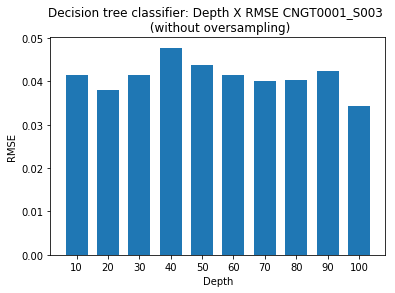

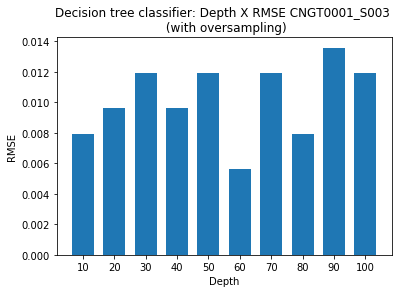

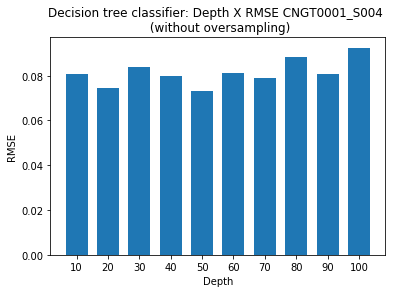

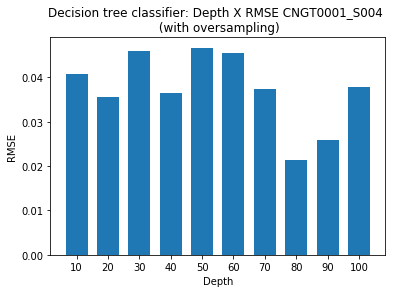

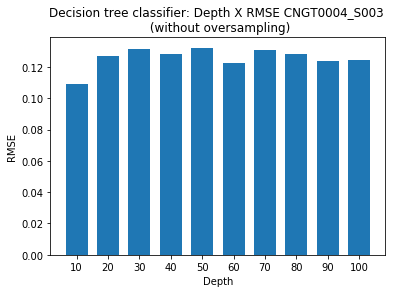

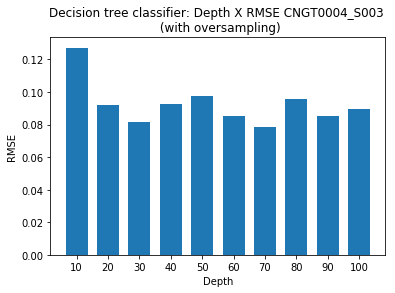

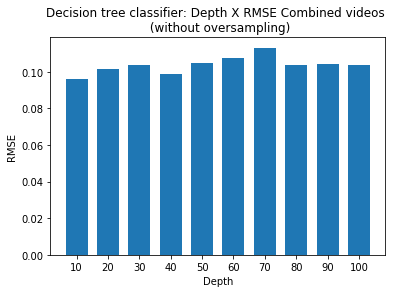

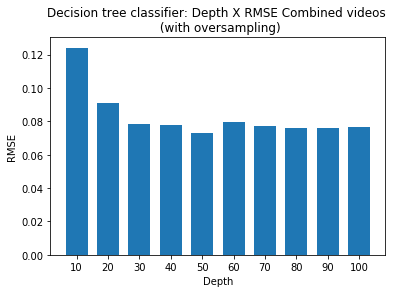

In [14]:
#Plot RMSE againt depth DCT
import matplotlib.pyplot as plt


#Show RMSEA x Depth for first 3 videos (separately)
for i in range(0,3):
    video_name = list(annotated_dictionary.keys())[i]
    if (i == 0):
        func.create_barplot(func.frange(10,110,10),rmse_depths_dt_first,"Decision tree classifier: Depth X RMSE {} \n (without oversampling)".format(video_name), 'Depth', 'RMSE',func.frange(10,110,10))
        func.create_barplot(func.frange(10,110,10),rmse_depths_dt_smote_first,"Decision tree classifier: Depth X RMSE {} \n (with oversampling)".format(video_name), 'Depth', 'RMSE',func.frange(10,110,10))
    
    elif(i ==1):
        func.create_barplot(func.frange(10,110,10),rmse_depths_dt_second,"Decision tree classifier: Depth X RMSE {} \n (without oversampling)".format(video_name), 'Depth', 'RMSE',func.frange(10,110,10))
        func.create_barplot(func.frange(10,110,10),rmse_depths_dt_smote_second,"Decision tree classifier: Depth X RMSE {} \n (with oversampling)".format(video_name), 'Depth', 'RMSE',func.frange(10,110,10))
    
    else:
        func.create_barplot(func.frange(10,110,10),rmse_depths_dt_third,"Decision tree classifier: Depth X RMSE {} \n (without oversampling)".format(video_name), 'Depth', 'RMSE',func.frange(10,110,10))
        func.create_barplot(func.frange(10,110,10),rmse_depths_dt_smote_third,"Decision tree classifier: Depth X RMSE {} \n (with oversampling)".format(video_name), 'Depth', 'RMSE',func.frange(10,110,10))

#Show RMSEA x Depth for first 3 videos (combined)
func.create_barplot(func.frange(10,110,10),rmse_depths_dt_allVideos,"Decision tree classifier: Depth X RMSE {} \n (without oversampling)".format("Combined videos"), 'Depth', 'RMSE',func.frange(10,110,10))
func.create_barplot(func.frange(10,110,10),rmse_depths_dt_smote_allVideos,"Decision tree classifier: Depth X RMSE {} \n (with oversampling)".format("Combined videos"), 'Depth', 'RMSE',func.frange(10,110,10))
    

When looking at the RMSE and corresponding depth, we can state the following optimal depths for the Decision Tree Classifier:
- First video (No oversampling): depth 20 with RMSE 0.0381
- First video (Oversampling): depth 60 with RMSE 0.00562
- Second video (No oversampling): depth 50 with RMSE 0.07322
- Second video (Oversampling): depth 80 with RMSE  0.0214
- Third Video (No oversampling): depth 10 with RMSE 0.1088
- Third video (Oversampling): depth 70 with RMSE 0.0784
- Comined videos (No oversampling): depth 10 with RMSE 0.0963
- Combined videos (Oversampling): 50 with RMSE 0.07298

We see that oversampling reduces the RMSE value and thus gives us better performance in classifying the PO sign. The oversampled data will thus be used for the final classification.

# 7. Perform Classification and Evaluate Results

With these optimal depths, we can perform final classification and evaluation the results.

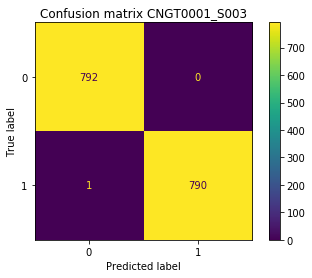

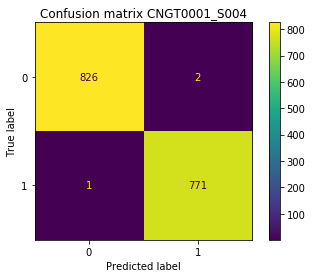

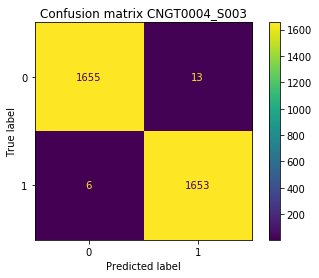

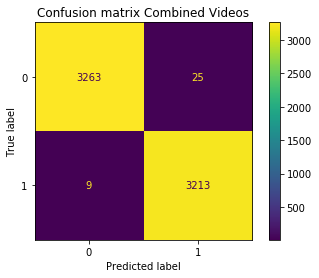

In [16]:
                  

hyperparams_first = {'depth': 60}
hyperparams_second = {'depth': 80}
hyperparams_third = {'depth': 70}
hyperparams_combined ={'depth': 50}

video_name_first =list(annotated_dictionary.keys())[0]
video_name_second = list(annotated_dictionary.keys())[1]
video_name_third = list(annotated_dictionary.keys())[2]

X_train_smote_concat, X_test_smote_concat, y_train_smote_concat,y_test_smote_concat = func.combine_data(annotated_dictionary,X_train_smote, y_train_smote, X_test_smote, y_test_smote )
                                     
y_pred_first = func.perform_classification('dt',X_train_smote[video_name_first],y_train_smote[video_name_first],X_test_smote[video_name_first],y_test_smote[video_name_first], hyperparams_first, "Confusion matrix {}".format(video_name_first))
y_pred_second = func.perform_classification('dt',X_train_smote[video_name_second],y_train_smote[video_name_second],X_test_smote[video_name_second],y_test_smote[video_name_second], hyperparams_second, "Confusion matrix {}".format(video_name_second))
y_pred_third = func.perform_classification('dt',X_train_smote[video_name_third],y_train_smote[video_name_third],X_test_smote[video_name_third],y_test_smote[video_name_third], hyperparams_third, "Confusion matrix {}".format(video_name_third))
y_pred_combined = func.perform_classification('dt',X_train_smote_concat,y_train_smote_concat,X_test_smote_concat,y_test_smote_concat, hyperparams_combined, "Confusion matrix Combined Videos")


Of these confusion matrices, the F1 score can be determined based on the TPs, TNs, FNs, FPs. The F1 score is the harmonic mean of the recall and the precision.

The precision and recall are defined as follows:
- _Precision_ : $\frac{TP}{(TP+FP)}$
- _Recall_: $\frac{TP}{(TP+FN)}$

Of these two metrices, the F1-score can be computed:

_F1_ : $\frac{2*(recall*precision)}{(recall+precision)}$

In [28]:
precision_first = 790/(790+1)
precision_second = 771/(771+2)
precision_third = 1653/(1653+2)
precision_combined = 3213/(3213+25)

recall_first = 790/(790+1)
recall_second = 771/(771+1)
recall_third = 1653/(1653+6)
recall_combined = 3213/(3213+9)

f1_first = (2*(precision_first*recall_first))/(precision_first+recall_first)
f1_second = (2*(precision_second*recall_second))/(precision_second+recall_second)
f1_third = (2*(precision_third*recall_third))/(precision_third+recall_third)
f1_combined = (2*(precision_combined*recall_combined))/(precision_combined+recall_combined)

print("F1-score CNGT0001_S003: {}".format(f1_first))
print("F1-score CNGT0001_S004: {}".format(f1_second))
print("F1-score CNGT0004_S003: {}".format(f1_third))
print("F1-score combined: {}".format(f1_combined))

F1-score CNGT0001_S003: 0.9987357774968394
F1-score CNGT0001_S004: 0.9980582524271844
F1-score CNGT0004_S003: 0.9975859987929995
F1-score combined: 0.9947368421052631


## 7.1. Plot PO sign distribution

Based on the annotated data, we can plot the distribution of the PO sign for each of the three videos.

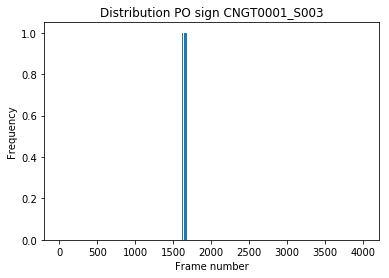

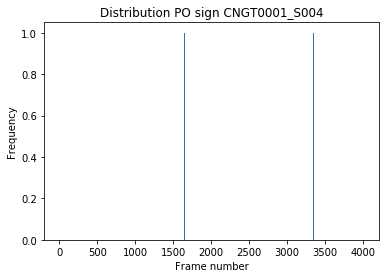

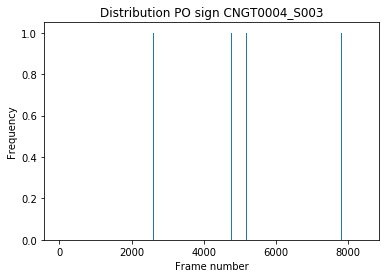

In [18]:
for i in range(0,3):
    video_name = list(annotated_dictionary.keys())[i]
    func.plot_distribution("Distribution PO sign {}".format(video_name),fns[video_name], fns_OP[video_name])